# Group 7 Report
### Authors: Emily Tian, Madhav Rao, Josephine Kaminaga, Alex Morifusa, Jay Leung

### Summary
In this project, we used intake form data from the data science capstone class to analyze various questions of interests. We were most interested in exploring relationships between self-reported comfort and confidence levels in statistics/math/programming, and various characteristics of students enrolled in the class (e.g. major, prior academic & research experience). After analyzing the data, we found that there was no significant relationship between the extent of prior coursework experience in subject areas & students’ self-reported comfort levels in those areas. We additionally found that regardless of whether students had completed the PSTAT major course requirements or not, they did not have significantly large differences in their comfort levels across all three recorded subject areas. Finally, we visually identified a positive relationship between computer science majors and self-reported levels of comfort with programming.

### Data Description
The data was obtained from a class intake form sent out to the Fall 2025 PSTAT197 Data Science Capstone class. This intake form collected basic demographic information, statistics/programming/math background including comfort/proficiency in each area, upper division courses and specific courses taken, and information about students’ interests in various domains of data science application. 60 students responded to the intake form. The majority (85%) of students are seniors, with a roughly equal gender divide. Most students are statistics & data science, economics, mathematics, computer science, or psychology majors/double majors.

### Questions
We wish to answer the following questions:

- Are students fluent in different programming languages interested in different project domains? 

- Can the number of upper-division programming & statistics courses a student has taken could predict their comfort level in each respective area?

- How does the confidence level differ between students who have completed all the required courses (PSTAT 120, 122, 126, and CS9) and those who have completed only some of them, excluding Computer Science Majors?

## Findings

## Are students fluent in different programming languages interested in different project domains? (Emily and Madhav)

### Specifically, what language and domains are associated with each other? (Emily)

We are curious on if it is possible to predict a student's project preference based on their programming language preference. Particularly, I am curious about predicting the project's domain, as I hypothesize that students who prefer R will prefer in the life sciences projects, whereas students who prefer Python prefer the technology domains.


To explore this, I first visualized histograms of student's domain preferences. There are a ton of categories, so I collapsed them into two main categories: science (e.g. biology, chemistry, etc.) or technology (e.g. software development, music & audio, etc.). 

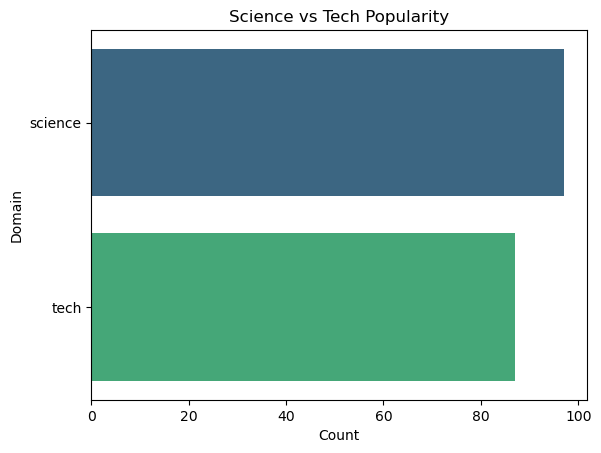

In [8]:
import pandas as pd

background = pd.read_csv('../data/background-clean.csv')
interest = pd.read_csv('../data/interest-clean.csv')
merge = pd.merge(background, interest, on='response_id', how='left')

merge.dom_y = merge.dom_y.str.split(';')
merge = merge.explode('dom_y')

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a countplot
'''plt.figure(figsize=(8, 5))
sns.countplot(y='dom_y', data=merge[merge['dom_y'].str.len() <= 40], palette='viridis') # filters out one random really long response
plt.title('Count of Each Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()'''

dom_map = {'Environmental science': 'science', 'Biology': 'science', 'Public health': 'science', 'Ecology': 'science',
'Neuroscience': 'science', 'Psychology': 'science', 'Chemistry': 'science',

'Technology': 'tech', 'Software development': 'tech', 'media/musical technology':'tech', 'Music & Audio': 'tech',
'Social or political science':'science', 'Entertainment':'tech','Economics / Accounting': 'science'
}

merge['domain'] = merge['dom_y'].map(dom_map)
merge['domain']

sns.countplot(y='domain', data=merge, palette='viridis')
plt.title('Science vs Tech Popularity')
plt.xlabel('Count')
plt.ylabel('Domain')
plt.show()

Then, I plotted the popularity of the domains by the programming language preferences. While Python is the most popular, within Python-fluent students, students are more interested in technology projects. The majority of students preferring R are more interested in science, on the other hand, and same for students with no preference. This makes sense because Python is more popular in the technology industry, whereas life sciences research more commonly uses R. 

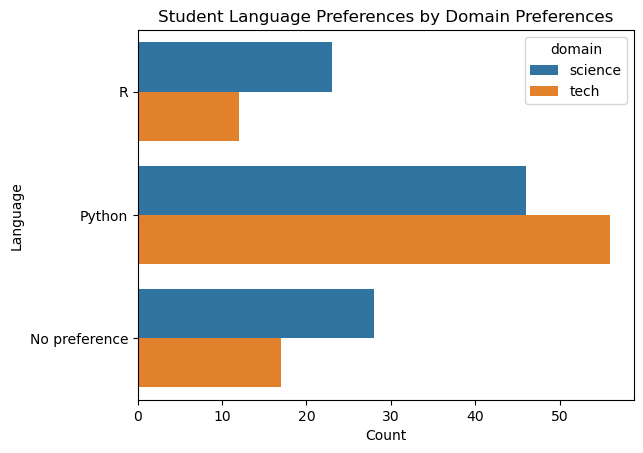

In [9]:
sns.countplot(y='lang', data=merge[merge['lang'].isin(['R', 'Python', 'No preference'])], hue='domain')
plt.xlabel('Count')
plt.ylabel('Language')
plt.title('Student Language Preferences by Domain Preferences')
plt.show()

### Logistic Regression Model: Is Python associated with technology domains?

I wanted to run a logistic regression model. First, I filtered the data to only have students who have a preference between R and Python. I set the default to R and science and ran a model:

log(p/(1-p)) = b0 + b1x1

Where log(p/(1-p)) represents the log odds of a student preferring technology. b0 represents the log odds of an R-fluent student  preferring a technology project, and b1 represents the relative increase in log odds for a Python-fluent student.

In [10]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Prepare the dataset
df_filtered = merge[merge['lang'].isin(['R', 'Python'])]
df_filtered = df_filtered[df_filtered['domain'].isin(['science', 'tech'])]

lang_map = {'R': 0, 'Python': 1}
domain_map = {'science': 0, 'tech': 1}

df_binarized = df_filtered
df_binarized['domain'] = df_binarized['domain'].map(domain_map)
df_binarized['lang'] = df_binarized['lang'].map(lang_map)
df_binarized[['domain', 'lang']]

# 2. Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.array(df_binarized['lang']).reshape(-1, 1), df_binarized['domain'], test_size=0.3, random_state=42)

# 3. Create and train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# 4. Make predictions on the test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Optional: Get coefficients and intercept
print(f"Coefficient: {model.coef_[0][0]:.2f}")
print(f"Intercept: {model.intercept_[0]:.2f}")

Model Accuracy: 0.64
Coefficient: 0.51
Intercept: -0.46


Based on the output, b0 = -.46, b1 = .51, it is unlikely for an R-fluent student to prefer a technology project, whereas a Python-fluent student prefers a technology project. This matches up with our data visualization. The accuracy is 0.66, which also makes sense, because students are still fairly split between science and technology domains. 

### Are language preferences associated with wanting industry vs academic projects? (Madhav)

Before even looking at the data I had hypothesized that most people would prefer using Python and would rather work on an industry project. After running my analysis I found this is the case. However I also came across something I didn't expect, that most people that prefer using R have no preference when it comes to research or industry. This is perhaps due to a lack of exposure to data science as a whole, thus they are unsure of popular tools and fields to be in. Interestingly, even those in the no preference group still mostly preferred working on industry projects, which I’m not really sure why this might be the case. Lastly I ran a simple logistic regression model with an 80% accuracy, however due to the small size and imbalance nature of the dataset I don't think this number is particularly significant.  

<Axes: xlabel='lang'>

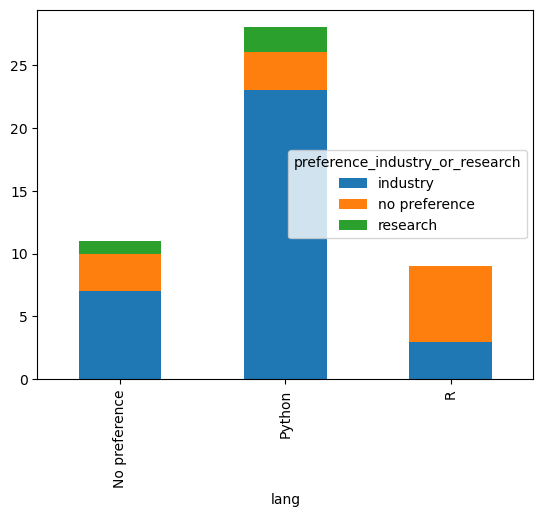

In [4]:
import os
import pandas as pd

df1 = pd.read_csv('../data/background-clean.csv')
df2 = pd.read_csv('../data/interest-clean.csv')
m1 = pd.merge(df1, df2, left_on='response_id', right_on='response_id', how='left')
m1.rename(columns={'do_you_have_any_preference_regarding_working_on_an_industry_project_or_a_research_lab_project': 'preference_industry_or_research'}, inplace=True)
m2 = m1[["lang", "preference_industry_or_research"]]
m2 = m2.drop(24)
import matplotlib.pyplot as plt

m2['preference_industry_or_research'] = m2['preference_industry_or_research'].str.lower()
m2['preference_industry_or_research'] = m2['preference_industry_or_research'].apply(lambda x: 'research' if 'research' in x else ('industry' if 'industry' in x else 'no preference'))
#EDA for the preference_industry_or_research column

#Now to relate the two columns 
cross_tab = pd.crosstab(m2['lang'], m2['preference_industry_or_research'])
cross_tab

#visualizing the crosstab
cross_tab.plot(kind='bar', stacked=True)



In [5]:
#Running a scikit-learn logistic regression model on the data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
#Encoding the categorical variables
le_lang = LabelEncoder()
le_preference = LabelEncoder()
m2['lang_encoded'] = le_lang.fit_transform(m2['lang'])
m2['preference_encoded'] = le_preference.fit_transform(m2['preference_industry_or_research'])
m2 = m2.dropna()

#Fit a log reg model on the data
X = m2[['lang_encoded']]
y = m2['preference_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[8 0 0]
 [1 0 0]
 [1 0 0]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1

    accuracy                           0.80        10
   macro avg       0.27      0.33      0.30        10
weighted avg       0.64      0.80      0.71        10



/Users/emilytian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilytian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilytian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Can the number of upper-division programming & statistics courses a student has taken could predict their comfort level in each respective area? (Josephine)

I performed necessary data manipulation on the given `background` dataframe. Firstly, I filtered out any students who answered “Unsure” to the domain specialization question. I also created the variables `n_programming` and `n_statistics` to represent the number of upper-division programming and statistics courses that students took, respectively. Among the upper-division programming courses, I counted PSTAT 100, 115, 122, 126, 131, 134, and 174, all CS courses, all LING courses, and ECON145. For upper-division statistics courses, I counted PSTAT 115, 120, 122, 126, 127, 174, and LING 104. These decisions are subjective, having been made on the basis of my own experiences in these classes and their descriptions in the course catalogue. This subjectivity may have impacted the model fit.

To determine whether the number of upper-division classes had an impact on the comfort level in programming/statistics, I fit two linear models. The first predicted comfort level in programming on the number of programming classes after controlling for domain specialization and research experience. The second predicted comfort level in statistics on the number of statistics classes after controlling for the same variables in the first model.

I found that neither the number of programming classes nor the number of statistics classes were statistically significant predictors of comfort level at the $\alpha$ = 0.05 significance level. For the programming model, it was estimated that a one-class increase in the number of programming classes taken resulted in a 0.092 increase in programming comfort level, with a p-value of 0.116. For the statistics model, it was estimated that a one-class increase in the number of statistics classes taken resulted in a 0.039 increase in statistics comfort level, with a p-value of 0.742. Again, neither result was significant.

I additionally plotted these results using ggplot to show visual insignificance.

In [ ]:
library(tidyverse)

# Read in data
background <- read_csv('data/background-clean.csv')
interest <- read_csv('data/interest-clean.csv')

# Question of interest
#
# After controlling from research experience and domain specialization,
# can the number of upper division programming & stats courses taken
# predict a student's comfort level in those respective areas?

# First, we will filter the data to just the information we need
# Using the base pipe |> since it's faster
background_filter <- background |>
  select(prog.comf, stat.comf, dom, rsrch,
         starts_with("PSTAT"), starts_with("LING"), 
         starts_with("CS"), ECON145) |>
  filter(dom != "Unsure")

# Create a count variable for no. of programming & no. of stats courses.
# Here we will count PSTAT100, 115, 122, 126, 131, 134, and 174
# All CS courses, LING 104, 110, 111, and ECON 145 as programming courses
# and PSTAT 115, 120, 122, 126, 127, 160, 174, and LING 104 as stats courses
background_final <- background_filter |>
  mutate(
    n_programming = PSTAT100 + PSTAT115 + PSTAT122 + PSTAT126 + PSTAT131 +
      PSTAT134 + PSTAT174 + CS5 + CS9 + CS16 + CS130 + CS165 + LING104 + 
      LING110 + LING111 + ECON145,
    n_statistics = PSTAT115 + PSTAT120 + PSTAT122 + PSTAT126 + PSTAT127 +
      PSTAT174 + LING104,
    dom_fct = as.factor(dom),
    rsrch_fct = as.factor(rsrch)
  ) |>
  select(prog.comf, stat.comf, dom_fct, rsrch_fct, n_programming, n_statistics)

# Fit linear model for effect of no. programming courses on programming comfort
mod_prog <- lm(prog.comf ~ dom_fct + rsrch_fct + n_programming,
               data = background_final)

# Fit linear model for effect of no. stats courses on statistics comfort
mod_stats <- lm(stat.comf ~ dom_fct + rsrch_fct + n_statistics,
                data = background_final)

# Check output of both models
summary(mod_prog)
summary(mod_stats)

# Create visual summary of data
plot_stats <- background_final |>
  ggplot(aes(x = n_statistics, y = stat.comf, col = dom_fct,
             shape = rsrch_fct)) +
  geom_point(size = 2.5) +
  geom_jitter(width = 0.25, height = 0.25, size = 2.5) +
  labs(x = "No. of statistics courses",
       y = "Statistics comfort level",
       title = "Statistics comfort level vs. no. of stats. courses",
       col = "Domain spec.",
       shape = "Rsrch. exp.") +
  theme_minimal()

plot_prog <- background_final |>
  ggplot(aes(x = n_programming, y = prog.comf, col = dom_fct,
             shape = rsrch_fct)) +
  geom_point(size = 2.5) +
  geom_jitter(width = 0.25, height = 0.25, size = 2.5) +
  labs(x = "No. of programming courses",
       y = "Programming comfort level",
       title = "Programming comfort level vs. no. of prog. courses",
       col = "Domain spec.",
       shape = "Rsrch. exp.") +
  theme_minimal()

# Save visual summar to results folder
ggsave("results/plot_stats.png", plot = plot_stats)
ggsave("results/plot_prog.png", plot = plot_prog)

![plot 1](../results/report_files/plot_prog.png)
![plot 2](../results/report_files/plot_stats.png)

The lack of a clear upwards trend in statistics/programming comfort based on the number of courses, as well as no clear pattern regarding research experience or domain specialization, reflects the insignificant results of the linear models.

## How does the confidence level differ between students who have completed all the required courses (PSTAT 120, 122, 126, and CS9) and those who have completed only some of them, excluding Computer Science Majors? (Alex and Jay)

### (Alex)
We wanted to determine the average comfort level of those who have and haven’t completed all of the PSTAT major requirements (CS9, PSTAT 120, PSTAT 122, PSTAT 126) to see how effective the required classes were for our confidence towards programming, math, and statistics. I hypothesize that those who have completed the required courses will have a higher average comfort level. Before I began, I needed to remove the CS majors in the class to specifically focus on statistics students. I saw that the students who haven’t taken PSTAT 122 or 126 were the likely CS majors, so I removed those who haven’t completed either courses from my dataframe.


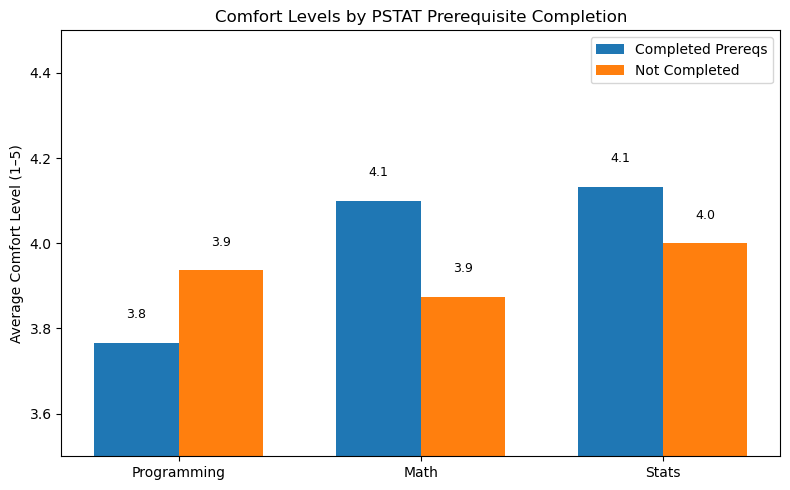

In [6]:
df = pd.read_csv('../data/background-clean.csv')
df = df[['response_id', 'prog.comf', 'math.comf', 'stat.comf', 'PSTAT120', 'PSTAT122', 'PSTAT126', 'CS9']]
# Create df for those who are done with PSTAT requirements and not done
df_done = df[(df['PSTAT120'] == 1) &
             (df['PSTAT122'] == 1) &
             (df['PSTAT126'] == 1) &
             (df['CS9'] == 1)]

df_not_done = df[(df['PSTAT120'] == 0) |
             (df['PSTAT122'] == 0) |
             (df['PSTAT126'] == 0) | 
             (df['CS9'] == 0)]

df_not_done = df_not_done[(df_not_done['PSTAT122'] == 1) |
                          (df_not_done['PSTAT126'] == 1)]

# Visual

import matplotlib.pyplot as plt
import numpy as np

skills = ['prog.comf', 'math.comf', 'stat.comf']

done_means = df_done[skills].mean()
not_done_means = df_not_done[skills].mean()

x = np.arange(len(skills))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width/2, done_means, width, label='Completed Prereqs')
bars2 = ax.bar(x + width/2, not_done_means, width, label='Not Completed')

ax.set_xticks(x)
ax.set_xticklabels(['Programming', 'Math', 'Stats'])
ax.set_ylabel('Average Comfort Level (1–5)')
ax.set_title('Comfort Levels by PSTAT Prerequisite Completion')
ax.legend()

ax.set_ylim(3.5, 4.5)
            
# Add labels on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


The results indicate there is not a large difference in average comfort level between students who have and have not completed all the required courses. Surprisingly, those who have not completed the required courses have a 0.1 higher average comfort level in programming. But, this may also just be due to the sample size. The results also indicate that the required courses in the major may not influence the comfort level in programming, math, and statistics of the student.

## Continued (Jay)
I investigated the question of whether the number of upper-division courses taken within PSTAT affected the confidence level of math, stats, and programming. I started by creating my dataframe from the background-clean.csv file. After creating the dataframe, I began by visualizing the data using a box plot, which plotted the number of upper-division courses on the x-axis and the confidence level on the y-axis, and generated three different plots—one for each subject. 
 

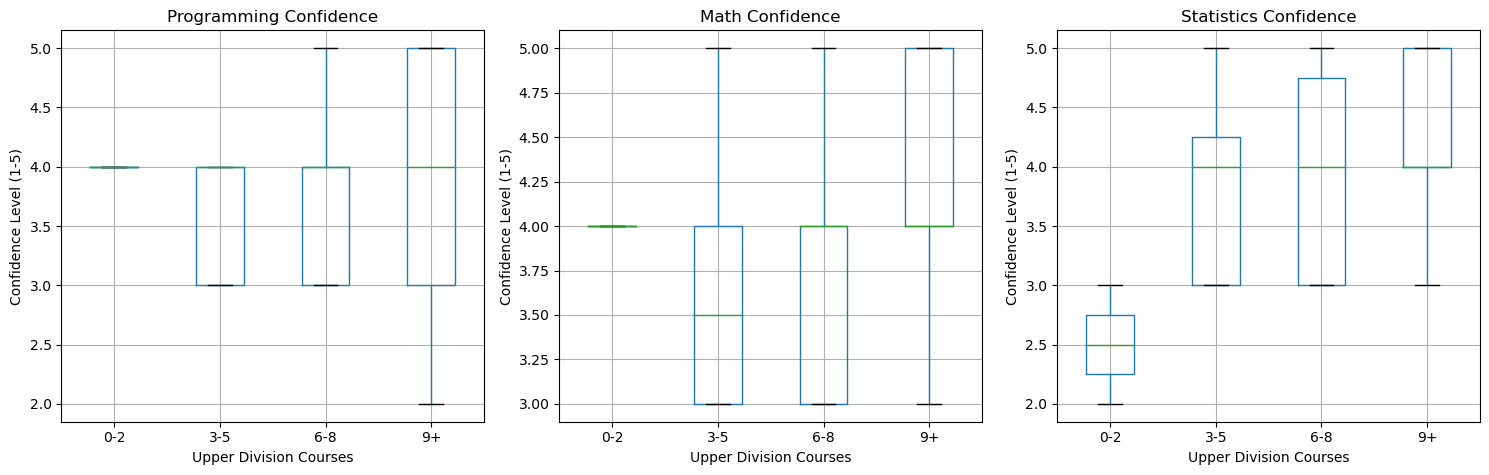

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
the_df = pd.read_csv('../data/background-clean.csv')
the_df

#Boxplot to see if confidence level increases with increased number of upper div courses - all students
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

confidence_vars = ['prog.comf', 'math.comf', 'stat.comf']
titles = ['Programming Confidence', 'Math Confidence', 'Statistics Confidence']

for i, (var, title) in enumerate(zip(confidence_vars, titles)):
    the_df.boxplot(column=var, by='updv.num', ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel('Upper Division Courses')
    axes[i].set_ylabel('Confidence Level (1-5)')
    axes[i].get_figure().suptitle('')

plt.tight_layout()
plt.show()

From these plots, we don’t particularly see a trend of increased confidence level with increased number of upper-division courses taken, except for in statistics. I then wanted to visualize this data with a bar plot by taking the average confidence levels. 

In [ ]:
#Bar plot to see if confidence level increases with increased number of upper div courses - all students
confidence_vars = ['prog.comf', 'math.comf', 'stat.comf']
categories = ['0-2', '3-5', '6-8', '9+']

means = the_df.groupby('updv.num')[confidence_vars].mean()

means = means.reindex(categories)

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(categories))
width = 0.25

bars1 = ax.bar(x - width, means['prog.comf'], width, label='Programming')
bars2 = ax.bar(x, means['math.comf'], width, label='Math')
bars3 = ax.bar(x + width, means['stat.comf'], width, label='Statistics')

ax.set_xlabel('Upper Division Courses')
ax.set_ylabel('Mean Confidence Level')
ax.set_title('Effect of Upper Division Courses on Confidence Levels')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

We can pretty much see a pattern similar to that of the box plot. I then worked to isolate CS majors and PSTAT majors by making whether students took the PSTAT 126 course a differentiating factor. PSTAT 126 is a required course for the Data Science Capstone for PSTAT majors, but PSTAT 126 is not a requirement for Computer Science, making this the perfect differentiator between the two majors. Other courses - like PSTAT 120 or CS9 - have the potential of including students from both majors. I then ran a bar plot to see subject confidence levels between the majors, just out of curiosity. 